## MNIST Metadata
This notebook will be used to generate the metadata required for the MNIST dataset. This is done to gather dataset statistics and stratify the folds.

In [1]:
import sys
sys.path.append("/home/jupyter-iroy2/advanced-neural-networks")

In [16]:
import numpy as np
import pandas as pd
import os
import torch
from tqdm import tqdm
import matplotlib.pyplot as plt

import advanced_neural_networks
from advanced_neural_networks.dataloader.mnist import MNISTDataset

import warnings
warnings.filterwarnings("ignore")

In [23]:
np.random.seed(42)

In [26]:
def partition_array(arr: np.ndarray, n_partitions):
    partitions = np.array_split(arr, n_partitions)
    return partitions


def stratify_kfolds(metadata_df: pd.DataFrame, kfolds: int):
    label_indices = {}
    labels = metadata_df["label"].unique()
    for label in labels:
        indices = np.array(metadata_df.loc[metadata_df["label"] == label].index)
        label_indices[label] = indices

    fold_info = {}
    
    for label in labels:
        lb_indices = label_indices[label]
        np.random.shuffle(lb_indices)
        label_partitions = partition_array(lb_indices, kfolds)

        for itr, fold in enumerate(range(kfolds)):
            fold_info[f"fold_{fold}"] = {f"{label}": label_partitions[itr]}

    return fold_info

In [4]:
module_dir = advanced_neural_networks.__path__[0]
dataloader_path = os.path.join(module_dir, "dataloader")
dataset_config = os.path.join(dataloader_path, "mnist_config.yaml")

In [7]:
mnist_train = MNISTDataset(config_file = dataset_config,
                          location = "cloud",
                          train = True,
                          transforms = [],
                          one_hot=False)

mnist_test = MNISTDataset(config_file = dataset_config,
                          location = "cloud",
                          train = False,
                          transforms = [],
                          one_hot=False)

In [8]:
train_metadata_df = pd.DataFrame()

for data_point in tqdm(mnist_train):
    x_image, label = data_point
    channels, height, width = list(x_image.shape)
    metadata = {
        "img_channels": channels,
        "height": height,
        "width": width,
        "label": label
    }

    train_metadata_df = pd.concat([train_metadata_df, pd.DataFrame([metadata])], ignore_index=True)
    

100%|██████████| 60000/60000 [00:30<00:00, 1956.49it/s]


In [14]:
train_metadata_df.head()

,img_channels,height,width,label
0,1,28,28,5
1,1,28,28,0
2,1,28,28,4
3,1,28,28,1
4,1,28,28,9


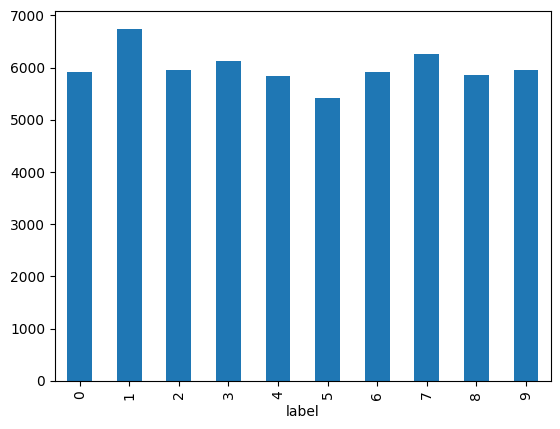

In [17]:
# summary df
train_size_summary = train_metadata_df.groupby("label").size()
train_size_summary.plot(kind = "bar")
plt.show()

In [18]:
## check for corruptions
condition = (train_metadata_df["img_channels"] != 1) | (train_metadata_df["height"] != 28) | (train_metadata_df["width"] != 28)
corrupt_df = train_metadata_df.loc[condition]
corrupt_df

,img_channels,height,width,label


In [19]:
test_metadata_df = pd.DataFrame()

for data_point in tqdm(mnist_test):
    x_image, label = data_point
    channels, height, width = list(x_image.shape)
    metadata = {
        "img_channels": channels,
        "height": height,
        "width": width,
        "label": label
    }

    test_metadata_df = pd.concat([test_metadata_df, pd.DataFrame([metadata])], ignore_index=True)

100%|██████████| 10000/10000 [00:04<00:00, 2106.71it/s]


In [20]:
test_metadata_df.head()

,img_channels,height,width,label
0,1,28,28,7
1,1,28,28,2
2,1,28,28,1
3,1,28,28,0
4,1,28,28,4


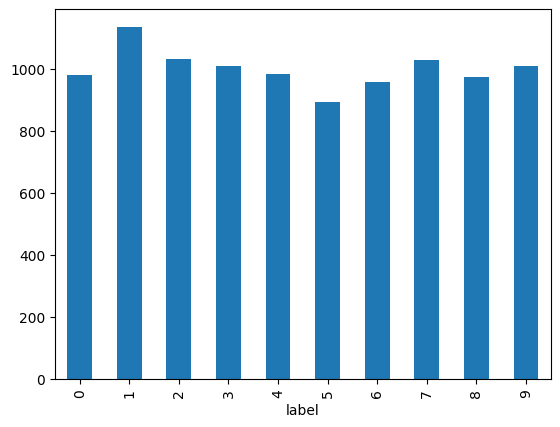

In [21]:
# summary df
test_size_summary = test_metadata_df.groupby("label").size()
test_size_summary.plot(kind = "bar")
plt.show()

In [22]:
## check for corruptions
condition = (test_metadata_df["img_channels"] != 1) | (test_metadata_df["height"] != 28) | (test_metadata_df["width"] != 28)
corrupt_df_test = test_metadata_df.loc[condition]
corrupt_df_test

,img_channels,height,width,label


In [31]:
## save metadata
save_dir = os.path.join(module_dir, "metadata")
train_df_path = os.path.join(save_dir, "mnist_train_metadata.csv")
train_metadata_df.to_csv(train_df_path, index=False)

test_df_path = os.path.join(save_dir, "mnist_test_metadata.csv")
test_metadata_df.to_csv(test_df_path, index=False)

In [27]:
## stratify and fold train metadata
train_folds = stratify_kfolds(train_metadata_df, kfolds = 10)

In [30]:
train_folds["fold_0"].keys()

dict_keys(['8'])